In [1]:
import graphspme as gspme
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from collections import namedtuple
from scipy import sparse
import scipy.sparse.linalg as spla

In [2]:
### Taken from https://github.com/equinor/localization_examples

"""Simulate prior from Auto-Regressive models"""
def rar1(T, phi):
    """simulate auto-regressive-1.
    The first element is simulated from stationary distribution.
    """
    x = np.empty([T])
    x[0] = np.random.normal(0, 1 / sqrt(1 - phi**2))
    for i in range(1, T):
        x[i] = phi * x[i - 1] + np.random.normal(0, 1)
    return x


def ne(i, T):
    """neighbours of element i in ar-1 process"""
    if not 0 <= i < T:
        raise ValueError("index i must be between 0 and T-1")
    if i == 0:
        return {1}
    elif i == T - 1:
        return {T - 1}
    else:
        return {i - 1, i + 1}


def auto_regressive_experiment(n, phi=0.8, T=1000):
    """An n-sample of AR-1(phi) at size T (prior sample)
    Additional information for data assimilation with localization is included
    """
    ExperimentResult = namedtuple(
        "ExperimentResult", ["X", "y", "cov_y", "H", "x_position", "x_neighbours"]
    )
    # ensemble
    X = np.array([rar1(T=T, phi=phi) for _ in range(n)])
    # noisy observation of sencory point in middle
    y = np.array([3.0])
    sd_y = 1.3
    cov_y = np.array([sd_y**2], ndmin=2)
    # param map to observations, mxp, p=T here
    H = np.array([0] * T, ndmin=2)
    H[0, np.rint(T / 2).astype(int) - 1] = 1  # middle sencor
    # x-positions (distance between points)
    x_position = [t for t in range(T)]
    # neighbours
    x_neighbours = {i: ne(i, T=T) for i in range(T)}
    return ExperimentResult(X, y, cov_y, H, x_position, x_neighbours)

In [3]:
def kf_update(y, H, Sigma, mu , Sigma_y):
    """Kalman filter update"""
    K = Sigma @ H.T @ np.linalg.inv(H@Sigma@H.T + Sigma_y)
    y_pred = H @ mu
    mu_posterior = mu + K @ (y - y_pred)
    Sigma_posterior = Sigma - K @ H @ Sigma
    return mu_posterior, Sigma_posterior

In [24]:
def if_update_nu(nu, H, y, Prec_y):
    """Information filter update of scaled mean"""
    H = sparse.csr_matrix(H)
    Prec_y = sparse.csr_matrix(Prec_y)
    return nu + (H.T @ Prec_y @ y).reshape(p,1)

def if_update_prec(Prec, Prec_y, H):
    """Information filter update of precision"""
    H = sparse.csr_matrix(H)
    Prec_y = sparse.csr_matrix(Prec_y)
    return Prec + H.T @ Prec_y @ H

In [25]:
n = 200
phi = 0.99
T=100
p = T
X, y, cov_y, H, x_position, x_neighbours = auto_regressive_experiment(n=n, phi=phi, T=T)

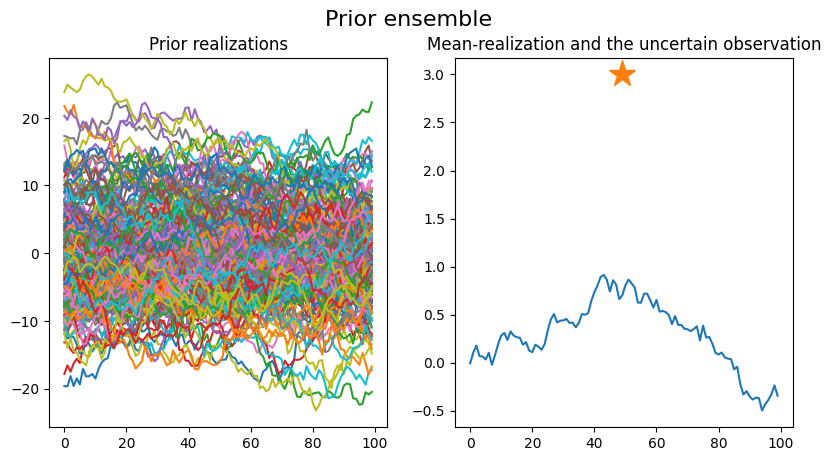

In [26]:
mu_x = np.array(X.mean(axis=0)).reshape(T,1)

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.suptitle('Prior ensemble', fontsize=16)
# the realizations
ax = fig.add_subplot(1,2,1)
for i in range(n):
    ax.plot(x_position, X[i,:], label= "realization {ind}".format(ind=i))
ax.set_title('Prior realizations')
# the mean
ax = fig.add_subplot(1,2,2)
ax.plot(x_position, mu_x)
ind_obs = np.where(H==1)[1]
ax.plot(ind_obs, [y], marker='*', ls='none', ms=20)
ax.set_title("Mean-realization and the uncertain observation")
plt.show()

In [27]:
## EnIF
# Estimate precision
# For each realization
# 1. transform x_i to scaled u_i = Prec@x_i
# 2. use u_i as scaled mean and update using IF update nu
# Update precision using IF update prec
# For each realization
# - transform back to ordinary space

# # Estimate precision
# build grpah in sparse matrix representation
graph_triplets = []
for i in x_neighbours:
    graph_triplets.append((i,i,1))
    for j in x_neighbours[i]:
        graph_triplets.append((i,j,1))
graph_i, graph_j, graph_v = zip(*graph_triplets)
graph = sparse.coo_matrix((graph_v, (graph_i, graph_j)), shape=(p,p)).tocsr()

# estimate precision w.r.t. graph
prec_prior = gspme.prec_sparse(X, graph, markov_order=1, cov_shrinkage=True, symmetrization=True)

In [28]:
# Update posterior precision
prec_posterior = if_update_prec(prec_prior, np.linalg.inv(cov_y), H)

In [30]:
# For each realization
# 1. transform x_i to scaled u_i = Prec@x_i
# 2. use u_i as scaled mean and update using IF update nu
X_posterior = np.empty((n,p))
for i in range(n):
    # perturb i
    noise = np.random.normal(0, np.sqrt(cov_y[0,0]))
    y_perturbed = y + noise
    # use realization as expectation
    mu_x_i = X[i,].reshape(p,1)
    # scale realizations
    nu_x_i = prec_prior @ mu_x_i
    # update each realization
    nu_post_i = if_update_nu(nu_x_i, H, y, np.linalg.inv(cov_y))
    # transform to original space
    x_post_i = spla.spsolve(prec_posterior, nu_post_i)
    X_posterior[i,:] = x_post_i.reshape(1,p)
mu_x_posterior = np.array(X_posterior.mean(axis=0)).reshape(T,1)

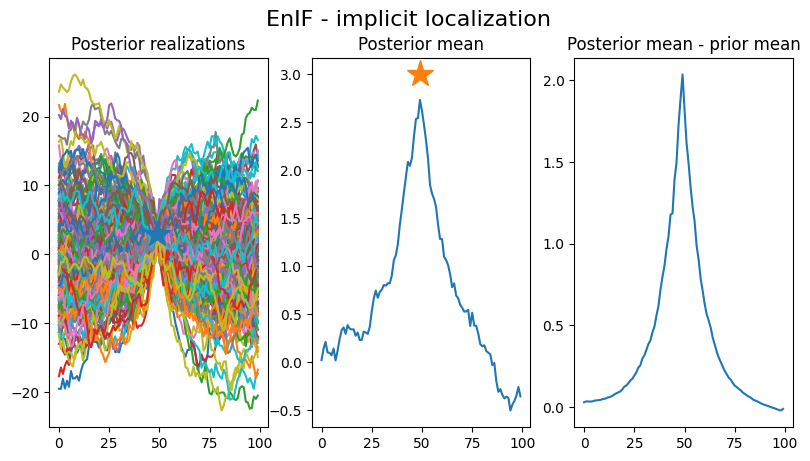

In [31]:
ind_obs = np.where(H==1)[1]
fig = plt.figure(figsize=plt.figaspect(0.5))
fig.suptitle('EnIF - implicit localization', fontsize=16)
ax = fig.add_subplot(1,3,1)
for i in range(n):
    ax.plot(x_position, X_posterior[i,:], label= "realization {ind}".format(ind=i))
ax.set_title('Posterior realizations')
ax.plot(ind_obs, [y], marker='*', ls='none', ms=20)
ax = fig.add_subplot(1,3,2)
ax.plot(x_position, mu_x_posterior)
ax.plot(ind_obs, [y], marker='*', ls='none', ms=20)
ax.set_title('Posterior mean')
ax = fig.add_subplot(1,3,3)
ax.plot(x_position, mu_x_posterior - mu_x)
ax.set_title('Posterior mean - prior mean')
plt.show()